In [1]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:           17Gi       6.6Gi       9.3Gi        26Mi       1.7Gi        10Gi
Swap:            0B          0B          0B


In [2]:
import pandas
import tensorflow

print(pandas.__version__)
print(tensorflow.__version__)

1.3.3
2.6.0


In [3]:
import datetime as dt
from pathlib import Path
import os
import time
from datetime import datetime
from IPython.display import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [4]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    data['Time'] = pd.to_datetime(data['Time'], unit='s')
    return data

data = load_data(train_path, None)
df = data[['UserId','ItemId','Time']]
df.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
df

,UserId,ItemId,Time
31,1,3186,2000-12-31 22:00:19
22,1,1270,2000-12-31 22:00:55
27,1,1721,2000-12-31 22:00:55
37,1,1022,2000-12-31 22:00:55
24,1,2340,2000-12-31 22:01:43
...,...,...,...
1000019,6040,2917,2001-08-10 14:40:29
999988,6040,1921,2001-08-10 14:41:04
1000172,6040,1784,2001-08-10 14:41:04
1000167,6040,161,2001-08-10 14:41:26


## 데이터 전처리
항목별 기본 분석, session length, session time, cleaning 등의 작업

### length

In [5]:
userID_length = df.groupby('UserId').size()
userID_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [6]:
userID_length.median(),userID_length.mean(),userID_length.min(),userID_length.max()

(96.0, 165.5975165562914, 20, 2314)

In [7]:
userID_length.quantile(0.999)

1343.181000000005

In [8]:
length_count = userID_length.groupby(userID_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum() # 누적상대도수
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

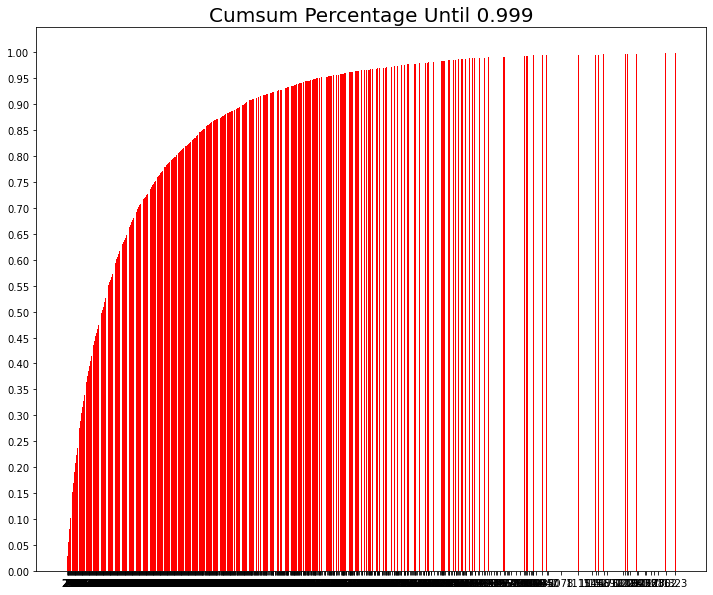

In [9]:
# userID 기준 하위 99.9%까지의 분포 누적합을 시각화

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

### Time

In [10]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [11]:
# 이부분을 이 데이터에 맞게 고치기

# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [12]:
data = cleanse_recursive(df, shortest=2, least_click=5)
data

,UserId,ItemId,Time
31,1,3186,2000-12-31 22:00:19
22,1,1270,2000-12-31 22:00:55
27,1,1721,2000-12-31 22:00:55
37,1,1022,2000-12-31 22:00:55
24,1,2340,2000-12-31 22:01:43
...,...,...,...
1000019,6040,2917,2001-08-10 14:40:29
999988,6040,1921,2001-08-10 14:41:04
1000172,6040,1784,2001-08-10 14:41:04
1000167,6040,161,2001-08-10 14:41:26


In [13]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    cutoff_time = final_time - dt.timedelta(days=n_days)

    # Train: cutoff 이전의 데이터
    train = data[data['Time'] < cutoff_time]

    # Test: cutoff 이후의 데이터, 단 아이템은 train에 있던 것만
    test = data[(data['Time'] >= cutoff_time) & (data['ItemId'].isin(train['ItemId']))]

    return train, test

In [14]:
tr, test = split_by_date(data, n_days=1)  # 마지막 이틀만 테스트용으로 분리
tr, val = split_by_date(tr, n_days=1)  # 마지막 이틀만 테스트용으로 분리

In [15]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [16]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 999550
	 Sessions: 6040
	 Items: 3416
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2003-02-26 16:18:03

* valid Set Stats Info
	 Events: 18
	 Sessions: 7
	 Items: 18
	 First Time : 2003-02-27 04:30:55
	 Last Time : 2003-02-27 17:45:48

* test Set Stats Info
	 Events: 43
	 Sessions: 7
	 Items: 43
	 First Time : 2003-02-27 17:50:41
	 Last Time : 2003-02-28 17:49:50



In [17]:
tr.shape

(999550, 3)

In [18]:
tr

,UserId,ItemId,Time
31,1,3186,2000-12-31 22:00:19
22,1,1270,2000-12-31 22:00:55
27,1,1721,2000-12-31 22:00:55
37,1,1022,2000-12-31 22:00:55
24,1,2340,2000-12-31 22:01:43
...,...,...,...
1000019,6040,2917,2001-08-10 14:40:29
999988,6040,1921,2001-08-10 14:41:04
1000172,6040,1784,2001-08-10 14:41:04
1000167,6040,161,2001-08-10 14:41:26


In [19]:
tr = cleanse_recursive(tr, shortest=2, least_click=5)
val = cleanse_recursive(val, shortest=2, least_click=3)
test = cleanse_recursive(test, shortest=2, least_click=3)

In [20]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [21]:
tr

,UserId,ItemId,Time,item_idx
31,1,3186,2000-12-31 22:00:19,0
22,1,1270,2000-12-31 22:00:55,1
27,1,1721,2000-12-31 22:00:55,2
37,1,1022,2000-12-31 22:00:55,3
24,1,2340,2000-12-31 22:01:43,4
...,...,...,...,...
1000019,6040,2917,2001-08-10 14:40:29,1248
999988,6040,1921,2001-08-10 14:41:04,370
1000172,6040,1784,2001-08-10 14:41:04,89
1000167,6040,161,2001-08-10 14:41:26,464


## 미니배치의구성
 Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성  

In [22]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [23]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Time,item_idx
31,1,3186,2000-12-31 22:00:19,0
22,1,1270,2000-12-31 22:00:55,1
27,1,1721,2000-12-31 22:00:55,2
37,1,1022,2000-12-31 22:00:55,3
24,1,2340,2000-12-31 22:01:43,4
36,1,1836,2000-12-31 22:02:52,5
3,1,3408,2000-12-31 22:04:35,6
7,1,2804,2000-12-31 22:11:59,7
47,1,1207,2000-12-31 22:11:59,8
0,1,1193,2000-12-31 22:12:40,9


In [24]:
tr_dataset.click_offsets

array([     0,     53,    182, ..., 999086, 999209, 999550], dtype=int32)

In [25]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 6037, 6038, 6039])

In [26]:
start = tr_dataset.click_offsets[tr_dataset.session_idx[[[0,1,2,3]]]]       # data 상에서 session이 시작된 위치를 가져옵니다.
end = tr_dataset.click_offsets[tr_dataset.session_idx[[0,1,2,3]] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.

start
end

array([ 53, 182, 233, 254], dtype=int32)

In [27]:
(end - start).min() -1

20

In [28]:
inp = tr_dataset.df['item_idx'].values[start + 20]
inp

array([ 20,  71, 185,  88])

In [29]:
target = tr_dataset.df['item_idx'].values[start + 20 + 1]
target

array([ 21,  72, 186,  56])

In [30]:
class FullSequenceDataLoader:
    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size
        self.sessions = self._build_sessions()

    def _build_sessions(self):
        sessions = []
        for start, end in zip(self.dataset.click_offsets[:-1], self.dataset.click_offsets[1:]):
            session = self.dataset.df['item_idx'].values[start:end]
            if len(session) >= 2:  # 최소 길이 보장
                sessions.append(session)
        return sessions

    def __iter__(self):
        for i in range(0, len(self.sessions), self.batch_size):
            batch = self.sessions[i:i+self.batch_size]
            input_batch = []
            target_batch = []
            for session in batch:
                input_batch.append(session[:-1])   # [A, B, C]
                target_batch.append(session[-1])   # D
            yield input_batch, target_batch

In [31]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

## 모델 구성

In [32]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [42]:
def create_model(args):
    # input: (batch, sequence_length, num_items)
    inputs = Input(shape=(None, args.num_items))  # 시퀀스 길이는 가변, 배치 크기도 가변
    # inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    x = GRU(args.hsz, return_sequences=False)(inputs)  # 마지막 hidden state만 출력
    x = Dropout(args.drop_rate)(x)
    predictions = Dense(args.num_items, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=predictions)
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model


# def create_model(args):
#     inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
#     gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
#     dropout = Dropout(args.drop_rate)(gru)
#     predictions = Dense(args.num_items, activation='softmax')(dropout)
#     model = Model(inputs=inputs, outputs=[predictions])
#     model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
#     model.summary()
#     return model


# from tensorflow.keras.layers import Input, GRU, Dropout, Dense
# from tensorflow.keras.models import Model
# from tensorflow.keras.losses import categorical_crossentropy
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.initializers import GlorotUniform
# import os

# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# def create_model(args):
#     inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    
#     gru, _ = GRU(
#         args.hsz,
#         stateful=True,
#         return_state=True,
#         name='GRU',
#         kernel_initializer=GlorotUniform()  # 핵심 수정!
#     )(inputs)
    
#     dropout = Dropout(args.drop_rate)(gru)
#     predictions = Dense(args.num_items, activation='softmax')(dropout)
    
#     model = Model(inputs=inputs, outputs=[predictions])
#     model.compile(
#         loss=categorical_crossentropy,
#         optimizer=Adam(args.lr),
#         metrics=['accuracy']
#     )
    
#     model.summary()
#     return model



# def create_model(args):
#     # input: (batch, sequence_length, num_items)
#     inputs = Input(shape=(None, args.num_items))  # 시퀀스 길이는 가변, 배치 크기도 가변
#     # inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
#     x = GRU(args.hsz, return_sequences=False)(inputs)  # 마지막 hidden state만 출력
#     x = Dropout(args.drop_rate)(x)
#     predictions = Dense(args.num_items, activation='softmax')(x)

#     model = Model(inputs=inputs, outputs=predictions)
#     model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
#     model.summary()
#     return model

from tensorflow.keras.layers import Embedding


def create_model(args):
    inputs = Input(shape=(None,), dtype='int32')  # (batch, seq_len)
    x = Embedding(input_dim=args.num_items, output_dim=args.hsz, mask_zero=True)(inputs)
    x = GRU(args.hsz)(x)
    x = Dropout(args.drop_rate)(x)
    predictions = Dense(args.num_items, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=predictions)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [43]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [44]:
model = create_model(args)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 50)          170800    
_________________________________________________________________
gru_1 (GRU)                  (None, 50)                15300     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3416)              174216    
Total params: 360,316
Trainable params: 360,316
Non-trainable params: 0
_________________________________________________________________


## 모델 학습

In [47]:
# def train_model(model, args):
#     train_dataset = SessionDataset(args.tr)
#     train_loader = FullSequenceDataLoader(train_dataset, batch_size=args.batch_size)

#     for epoch in range(1, args.epochs + 1):
#         tr_loader = tqdm(train_loader, desc=f'Train Epoch {epoch}')

#         for input_seqs, target_items in tr_loader:
#             # One-hot encoding
#             input_seqs_padded = pad_sequences(input_seqs, padding='pre')  # 또는 'post'
#             input_ohe = to_categorical(input_seqs_padded, num_classes=args.num_items)  # (B, T, num_items)
#             target_ohe = to_categorical(target_items, num_classes=args.num_items)  # (B, num_items)

#             result = model.train_on_batch(input_ohe, target_ohe)
#             tr_loader.set_postfix(train_loss=result[0], accuracy=result[1])

#         val_recall, val_mrr = get_metrics(args.val, model, args, args.k)
#         print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:.4f}")
#         print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:.4f}")

def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = FullSequenceDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        tr_loader = tqdm(train_loader, desc=f'Train Epoch {epoch}')

        for input_seqs, target_items in tr_loader:
            # 정수 인덱스 기반 패딩
            input_seqs_padded = pad_sequences(input_seqs, padding='pre')  # (B, T)

            # target은 원-핫 인코딩
            target_ohe = to_categorical(target_items, num_classes=args.num_items)  # (B, num_items)

            # 학습
            result = model.train_on_batch(input_seqs_padded, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy=result[1])

        # 검증
        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)
        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:.4f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:.4f}")


# def get_metrics(data, model, args, k: int):
#     dataset = SessionDataset(data)
#     loader = FullSequenceDataLoader(dataset, batch_size=args.batch_size)

#     recall_list, mrr_list = [], []

#     for input_seqs, label in tqdm(loader, desc='Evaluation'):
#         input_ohe = to_categorical(input_seqs, num_classes=args.num_items)  # (B, T, num_items)

#         pred = model.predict(input_ohe, batch_size=args.batch_size)  # (B, num_items)
#         pred_arg = tf.argsort(pred, direction='DESCENDING')

#         for i in range(len(label)):
#             recall_list.append(recall_k(pred_arg[i], label[i], k))
#             mrr_list.append(mrr_k(pred_arg[i], label[i], k))

#     return np.mean(recall_list), np.mean(mrr_list)

def get_metrics(data, model, args, k: int):
    dataset = SessionDataset(data)
    loader = FullSequenceDataLoader(dataset, batch_size=args.batch_size)

    recall_list, mrr_list = [], []

    for input_seqs, labels in tqdm(loader, desc='Evaluation'):
        # 정수 인덱스 기반 시퀀스를 패딩
        input_seqs_padded = pad_sequences(input_seqs, padding='pre')  # (B, T)

        # 예측
        preds = model.predict(input_seqs_padded, batch_size=args.batch_size)  # (B, num_items)
        pred_ranks = tf.argsort(preds, axis=1, direction='DESCENDING')  # (B, num_items)

        # 메트릭 계산
        for i in range(len(labels)):
            recall_list.append(recall_k(pred_ranks[i], labels[i], k))
            mrr_list.append(mrr_k(pred_ranks[i], labels[i], k))

    return np.mean(recall_list), np.mean(mrr_list)

## 모델 테스트 
염병할

In [46]:
train_model(model, args)

Train Epoch 1: 95it [02:33,  1.61s/it, accuracy=0, train_loss=7.46]     
Evaluation: 0it [00:00, ?it/s]


	 - Recall@20 epoch 1: nan
	 - MRR@20    epoch 1: nan


Train Epoch 2: 95it [03:03,  1.93s/it, accuracy=0, train_loss=7.11]     
Evaluation: 0it [00:00, ?it/s]


	 - Recall@20 epoch 2: nan
	 - MRR@20    epoch 2: nan


Train Epoch 3: 95it [03:03,  1.93s/it, accuracy=0, train_loss=6.9]      
Evaluation: 0it [00:00, ?it/s]

	 - Recall@20 epoch 3: nan
	 - MRR@20    epoch 3: nan


In [48]:
train_model(model, args)

Train Epoch 1: 95it [03:03,  1.94s/it, accuracy=0.0417, train_loss=6.75]
Evaluation: 0it [00:00, ?it/s]


	 - Recall@20 epoch 1: nan
	 - MRR@20    epoch 1: nan


Train Epoch 2: 95it [03:03,  1.93s/it, accuracy=0, train_loss=6.62]     
Evaluation: 0it [00:00, ?it/s]


	 - Recall@20 epoch 2: nan
	 - MRR@20    epoch 2: nan


Train Epoch 3: 95it [03:02,  1.92s/it, accuracy=0, train_loss=6.46]     
Evaluation: 0it [00:00, ?it/s]

	 - Recall@20 epoch 3: nan
	 - MRR@20    epoch 3: nan


In [65]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    data['Time'] = pd.to_datetime(data['Time'], unit='s')
    return data

data = load_data(train_path, None)
df = data[['UserId','ItemId','Time']]
df.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
df

,UserId,ItemId,Time
31,1,3186,2000-12-31 22:00:19
22,1,1270,2000-12-31 22:00:55
27,1,1721,2000-12-31 22:00:55
37,1,1022,2000-12-31 22:00:55
24,1,2340,2000-12-31 22:01:43
...,...,...,...
1000019,6040,2917,2001-08-10 14:40:29
999988,6040,1921,2001-08-10 14:41:04
1000172,6040,1784,2001-08-10 14:41:04
1000167,6040,161,2001-08-10 14:41:26


In [73]:
end_date = '2003-01-01'
df_1 = df[df['Time'] >= end_date]

In [74]:
df_1

,UserId,ItemId,Time
8704,59,2997,2003-01-07 18:02:48
8721,59,2147,2003-01-07 18:03:59
8781,59,2369,2003-01-07 18:04:24
8797,59,3408,2003-01-07 18:04:52
8808,59,2712,2003-01-07 18:04:52
...,...,...,...
984731,5950,3948,2003-02-27 18:13:57
984682,5950,3578,2003-02-27 18:14:30
984475,5950,3793,2003-02-27 18:15:10
984660,5950,3555,2003-02-27 18:15:37


In [83]:
# 추천 시스템을 위한 GRU 학습용 데이터 준비 및 데이터로더 구현 코드

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Masking
from tensorflow.keras.utils import to_categorical
import datetime as dt


# 시간순 정렬
df_2 = df_1.sort_values(by=['UserId', 'Time'])

# ------------------ 2. 정수 인코딩 ------------------
item_encoder = LabelEncoder()
df_2['ItemIdx'] = item_encoder.fit_transform(df_2['ItemId'])

In [84]:
df_2

,UserId,ItemId,Time,ItemIdx
8704,59,2997,2003-01-07 18:02:48,1232
8721,59,2147,2003-01-07 18:03:59,889
8781,59,2369,2003-01-07 18:04:24,980
8797,59,3408,2003-01-07 18:04:52,1394
8808,59,2712,2003-01-07 18:04:52,1124
...,...,...,...,...
984731,5950,3948,2003-02-27 18:13:57,1596
984682,5950,3578,2003-02-27 18:14:30,1462
984475,5950,3793,2003-02-27 18:15:10,1539
984660,5950,3555,2003-02-27 18:15:37,1456


In [85]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [86]:
dataset = SessionDataset(df_2)
dataset.df.head(10)

,UserId,ItemId,Time,ItemIdx
8704,59,2997,2003-01-07 18:02:48,1232
8721,59,2147,2003-01-07 18:03:59,889
8781,59,2369,2003-01-07 18:04:24,980
8797,59,3408,2003-01-07 18:04:52,1394
8808,59,2712,2003-01-07 18:04:52,1124
8809,59,2716,2003-01-07 18:05:31,1126
8836,59,1959,2003-01-07 18:06:27,773
8834,59,2686,2003-01-07 18:06:48,1113
8798,59,2396,2003-01-07 18:07:15,990
8815,59,314,2003-01-07 18:07:15,138
